<a href="https://colab.research.google.com/github/edwin-19/ImageZShot/blob/main/CLiPSeg_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.6 MB/s eta 0:00:00


In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar

In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from xml.etree import ElementTree as ETree
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import random

import os
import glob
import torch
from pathlib import Path

In [4]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model.eval();

Downloading:   0%|          | 0.00/380 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/974 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/603M [00:00<?, ?B/s]

# Simple inference

In [8]:
images_path = Path('VOCdevkit/VOC2007/JPEGImages')
imgs = list(images_path.glob('*.jpg'))

In [9]:
img = Image.open(imgs[0])

In [11]:
prompts = ['baby', 'background']
inputs = processor(text=prompts, images=[img] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

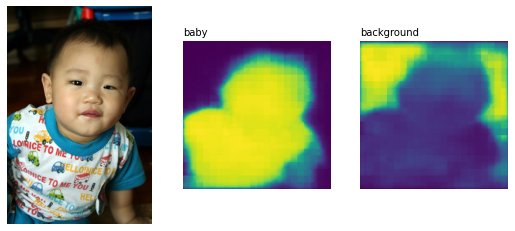

In [15]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(img)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

# Image guided

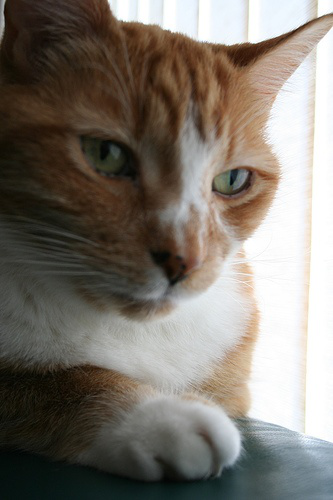

In [16]:
image = Image.open(np.random.choice(imgs))

In [17]:
encoded_image = processor(images=[image], return_tensors="pt")
encoded_prompt = processor(images=[image], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

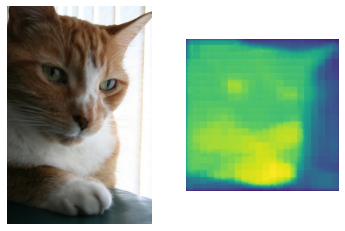

In [18]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))

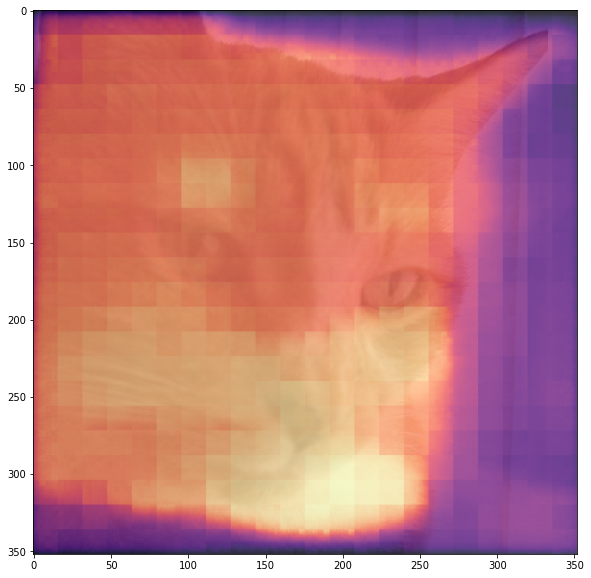

In [25]:
# Stack
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.imshow(torch.sigmoid(preds[0]), cmap='magma', alpha=0.8)

# Batch Infer

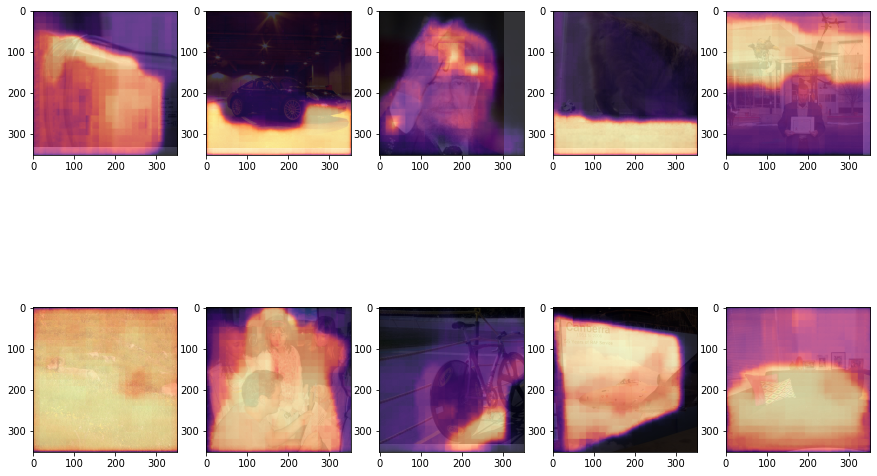

In [26]:
random_imgs = np.random.choice(imgs, 10)

plt.figure(figsize=(15, 10))
for index, img in enumerate(random_imgs):
  image = Image.open(img)

  encoded_image = processor(images=[image], return_tensors="pt")
  encoded_prompt = processor(images=[image], return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
  preds = outputs.logits.unsqueeze(1)
  preds = torch.transpose(preds, 0, 1)

  plt.subplot(2, 5, index + 1)
  plt.imshow(image)
  plt.imshow(torch.sigmoid(preds[0]), cmap='magma', alpha=0.8)